2 The Support Vector Machine (SVM) (Continued)
-------------------

### 2.3 The SVM on real world GIS and Remote Sensing datasets.

You will be working with the same dataset containing sample land use and land cover (LULC) information. You will train and test your **SVM** on these sample LULC classes.

In [ ]:
# Before reading the data we need to first clone the data on Github to our Colab workspace
!git clone https://github.com/jonwangio/uu_ml

In [4]:
# Same real world dataset as you have already encountered in the previous sessions.
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
% pip install geopandas
import geopandas as gpd
% pip install rasterio
import rasterio
from rasterio.plot import show
from sklearn.svm import SVC

# The data contains sample LULC areas around dutch provinces North Holland and Utrecht.
aoi = gpd.read_file('uu_ml/data/aoi_NL_5_classes.shp')

print (aoi.head())

     id   land_cover  class                                           geometry
0  None  Clear water     11  POLYGON ((638038.588 5776433.484, 637916.087 5...
1  None  Clear water     11  POLYGON ((638293.014 5776226.174, 638669.940 5...
2  None  Clear water     11  POLYGON ((642646.516 5779109.663, 643438.062 5...
3  None  Clear water     11  POLYGON ((658307.816 5795505.970, 659438.596 5...
4  None  Clear water     11  POLYGON ((617048.489 5789668.319, 617764.649 5...


C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\geopandas\plotting.py:644: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


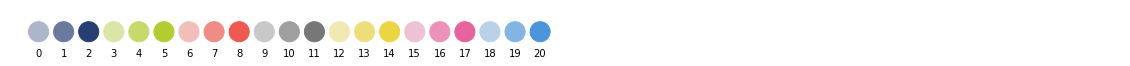

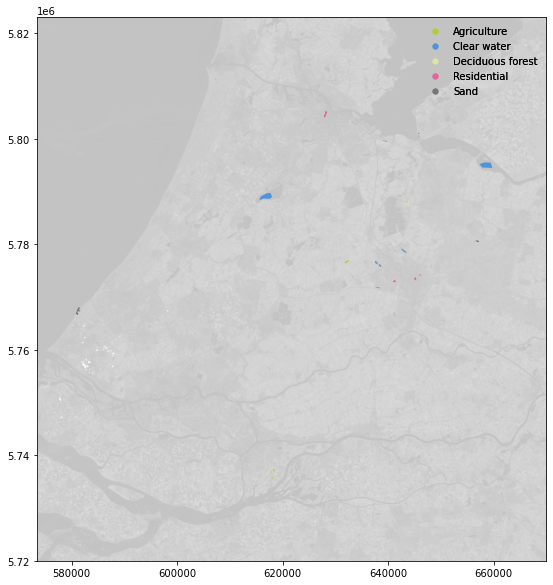

In [5]:
# Below is a visualization of the sample LULC areas superimposed on a satellite image of part of the Netherlands
file_location = 'uu_ml/data/b5_2015.TIF'
b5_2020 = rasterio.open(file_location, nodata=0)

# We also prepare the color codes for visualization
colors = [(257, 71, 27), (98, 93, 78), (14, 79, 58), (26, 0, 50), (75, 90, 85), (347, 72, 60), (246, 79, 60)]
cols = []
for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=4)
    for rgb in pal[1:]:
        cols.append(rgb)

# A preview of color codes. Please delete the triple quotation marks to run the code.

fig, ax = plt.subplots(figsize=(20, 5))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))
    plt.text(i, -1, i, horizontalalignment='center')
    ax.set_axis_off()
    ax.set_aspect(1)
    ax.autoscale()
    plt.xlim(-1.25,43.25)
    plt.ylim(-1,1)


# Assign color codes to LULC types 
symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[13],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig,ax = plt.subplots(1,1, figsize=(10,10))
show(b5_2020, ax=ax, cmap='gray', alpha=0.25)
aoi.plot(ax=ax, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax.add_artist(leg_points)

Prepare the training and test datasets from the sample LULC types in AOIs. We will start with fewer bands, let's say two, and then add more bands to evaluate the model performance. Hence, in the sense of **supervised learning**, the inputs will be the image bands, and the manually delineated LULC types in the AOIs will be the labels. In our case, we will be stacking all of them and split the stack into training and test sets, so that the inputs and labels will be split accordingly.

In [38]:
# Import necessary modules and functionalities

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imread
from sklearn.svm import SVC

# As before, we start with loading and stacking the image bands.
# Again, we start with 2 bands that appeared to be useful for the small dataset.
file_list = ['uu_ml/data/b5_2015.TIF', 'uu_ml/data/b6_2015.TIF']  # List to store file names

# You can print to see how the file_list looks like
print(file_list)

# Read the files and stack them together by calling their names
# Use the 'for' loop to iterate over the names to read files
stack = np.array([])  # Empty array to store the stacked images
for file in file_list:
    img = imread(file)  # Read each image file
    print(img.shape)  # Each time, also check the size of the image
    
    # In order to do clustering, image should be reshaped into a single column
    img_col = img.reshape(-1, 1)
    
    # Each time put the reshaped image into the stack
    stack = np.hstack((stack,img_col)) if stack.size else img_col
    # Also to check the size of the stack
    print(stack.shape)

['data/b5_2015.TIF', 'data/b6_2015.TIF']
(3434, 3221)
(11060914, 1)
(3434, 3221)
(11060914, 2)


In [39]:
# We also need to rasterize our manually delineated LULC types in the AOIs as we did in previous sessions
# Use the rasterio again to rasterize the *.shp file

from rasterio import features

# Labels from the AOIs
aoi = gpd.read_file('uu_ml/data/aoi_NL_5_classes.shp')
aoi['aoi_cat'] = pd.Categorical(aoi['class'])

# Rasterize
rst = rasterio.open('uu_ml/data/b5_2015.TIF')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

# Burn the AOIs *.shp file into raster and save it
out_rst = 'uu_ml/data/aoi_rasterized.tif'
with rasterio.open(out_rst, 'w+', **meta) as out:
    out_arr = out.read(1)

    # Create a generator of geom, value pairs to use in rasterizing
    shapes = ((geom,value) for geom, value in zip(aoi.geometry, aoi.aoi_cat))

    burned = features.rasterize(shapes=shapes, fill=0, out=out_arr, transform=out.transform)
    out.write_band(1, burned)

In [40]:
# Load the rasterized LULC types in the AOI and concatenate it together with the images

aoi_rst = rasterio.open('uu_ml/data/aoi_rasterized.tif').read(1)

# Stack the label with the input bands
data = np.c_[stack, aoi_rst.reshape(-1,)]

# Of course, we are only interested in pixels with LULC type labelled
data = data[np.where(data[:,data.shape[1]-1]!=0)]

In [55]:
# Recall our function for preparing training and test datasets.
# This time we re-write it a little bit to let the users of the function to split the data into training and test sets.

def trainTestSplit(x, y, training_proportion):
    data = np.c_[x, y]
    np.random.shuffle(data)  # Shuffle the data so that LULC types can spread over training and test sets
    x_train = data[:int(training_proportion*len(data)), :2]  # 70% of data for training
    x_test = data[int(training_proportion*len(data)):, :2]  # 30% for testing
    y_train = data[:int(training_proportion*len(data)), 2:].reshape(-1,)  # 70% of data for training
    y_test = data[int(training_proportion*len(data)):, 2:].reshape(-1,)  # 30% for testing
    return x_train, y_train, x_test, y_test

# This time, use a very small proportion of the data for training, say, 30%.
X_train, Y_train, X_test, Y_test = trainTestSplit(data[:,:-1], data[:,-1], 0.3)

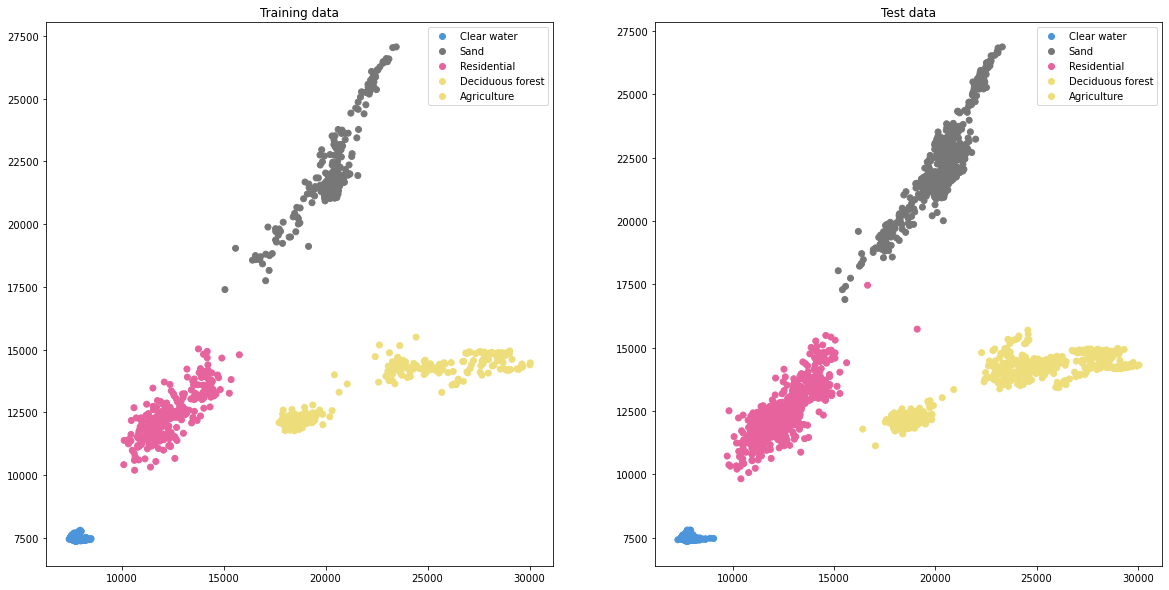

In [63]:
# Assign color codes to LULC types for visualizing the datasets

from matplotlib.colors import ListedColormap

symbology2 = {11: cols[20],
              21: cols[11],
              31: cols[17],
              52: cols[5],
              61: cols[13]}

cm = ListedColormap(symbology2.values())
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

# Visualize
classes = ['Clear water', 'Sand', 'Residential', 'Deciduous forest', 'Agriculture']

fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))

scatter1 = ax1.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm, vmin=imin, vmax=imax, label='LULC types')
ax1.set_title('Training data')
ax1.legend(handles=scatter1.legend_elements()[0], labels=classes)

ax2.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm, vmin=imin, vmax=imax, label='LULC types')
ax2.set_title('Test data')
ax2.legend(handles=scatter1.legend_elements()[0], labels=classes)

Having prepared and also visualized the training and test datasets, we can assess the performance the **SVM**. Let's start with a simple **SVM** with ***linear*** kernel. We continue to use the **SVM** functionality from the ***sklearn*** module.

In [67]:
svm_lin = SVC(kernel='linear', C=1E6)
svm_lin.fit(X_train, Y_train)

SVC(C=1000000.0, kernel='linear')

After fitting our model to the training data, the **SVM** functionality from the ***sklearn*** allows us to quickly assess the accuracy of our trained model on the test dataset.

In [97]:
print(svm_lin.score(X_test, Y_test)*100)

99.92404101785036


As you noticed, the accuracy is quite high. How does this accuracy make sense in the feature space? Recall how we visualized the decision boundaries for our dummy dataset? Now we would like to visualize the boundary again, but this time, for multi-classes, which is different from the simple case of 2-class classification in the dummy dataset.

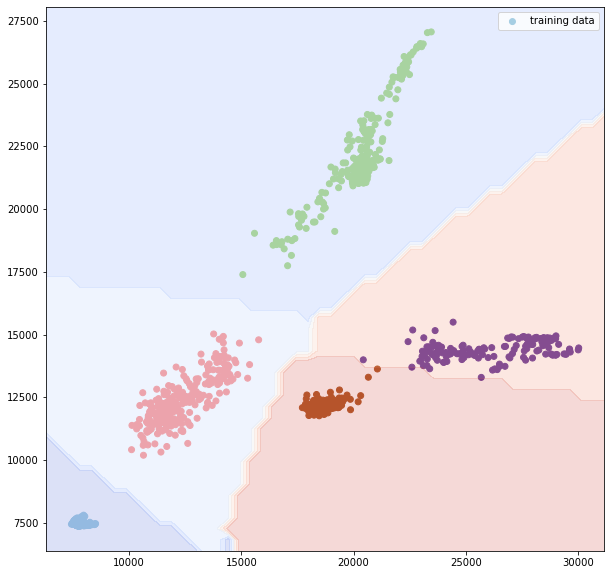

In [106]:
def plot_svc_decision(model, ax=None):
    '''Plot the decision function for a 2D SVC'''
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 50)
    y = np.linspace(ylim[0], ylim[1], 50)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.predict(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contourf(X, Y, P, cmap=plt.cm.coolwarm, alpha=0.2)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

fig = plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
plot_svc_decision(svm_lin)
plt.legend()

### 2.4 Model evaluation.

As you might be wondering when you were playing with the dummy dataset that how the decision boundaries are updated, you can of course apply the same concept to visualize how the decision boundaries evolve with different numbers of iterations. Please note that we are not visualizing how the decision boundaries are updated incrementally, but just how the boundaries look like with different number of iterations!

We can also explore further how the **training** will be improving the performance of the model by plotting the iterations of **training** incrementally. A **learning curve** will be a type of such plot.

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


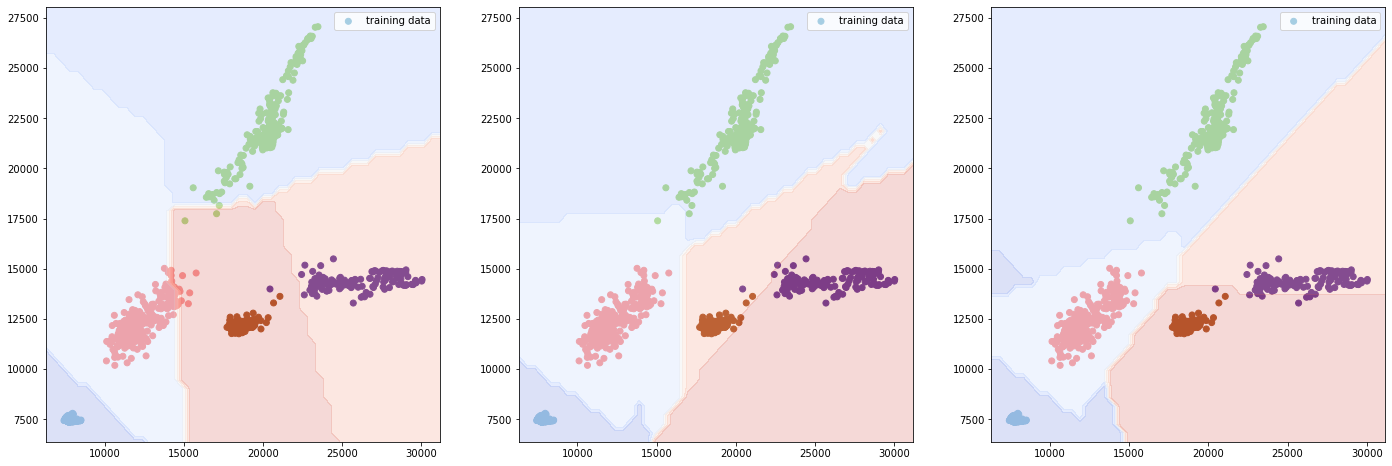

In [118]:
# Simply repeat the training procedure with different number of iterations.

fig = plt.figure(figsize=(24,8))
for i in range(3):
    plt.subplot(1,3,i+1)
    
    svm_lin = SVC(kernel='linear', C=1E6, max_iter=i+1)
    svm_lin.fit(X_train, Y_train)

    plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
    plot_svc_decision(svm_lin)
    plt.legend()

We can further inspect how the accuracy improves with increasing number of iterations, so that we will have an idea of how the **SVM** can be properly or suffciently trained with different number of iterations. Please recall how we used the **confusion matrix** to make simple comparison between predicted and observed data, and how different types of accuracy metrics are derived.

In [119]:
# We can first put the predictions on the test dataset in a confusion matrix

import pandas as pd

Y_pred = pd.Series(list(svm_lin.predict(X_test)), name='SVM_rbf prediction')  # Store the predicted value in Y_pred
Y_actu = pd.Series(list(Y_test), name='Manual delineation')

# As before in the session for K-means, we map the LULC codes to the actual name of LULC types

# First we need a mapping from the LULC codes to the actual LULC type name.
code_lulc = { 52: 'Agriculture',
              11: 'Clear water',
              61: 'Deciduous forest',
              31: 'Residential',
              21: 'Sand'}

# Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
Y_actu2 = Y_actu.replace(code_lulc)
Y_pred2 = Y_pred.replace(code_lulc)

# Show the LULC coded confusion matrix
df_confusion2 = pd.crosstab(Y_actu2, Y_pred2)
df_confusion2

SVM_rbf prediction,Agriculture,Clear water,Deciduous forest,Residential,Sand
Manual delineation,,,,,
Agriculture,358,0,42,0,0
Clear water,0,3260,0,0,0
Deciduous forest,0,0,330,0,0
Residential,1,0,0,639,1
Sand,0,0,0,0,635


We can of course inspect more detailed accuracy by using metrics that we have used in the previous sessions. How does the accuracy look like compared to the accuracy we've already obtained above from the ***svm_lin.score***?

In [120]:
# Print out more detailed accuracy assessment report

from sklearn.metrics import classification_report

print(classification_report(Y_actu2, Y_pred2))

                  precision    recall  f1-score   support

     Agriculture       1.00      0.90      0.94       400
     Clear water       1.00      1.00      1.00      3260
Deciduous forest       0.89      1.00      0.94       330
     Residential       1.00      1.00      1.00       641
            Sand       1.00      1.00      1.00       635

        accuracy                           0.99      5266
       macro avg       0.98      0.98      0.98      5266
    weighted avg       0.99      0.99      0.99      5266



C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=2).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


                  precision    recall  f1-score   support

     Agriculture       1.00      1.00      1.00       400
     Clear water       1.00      1.00      1.00      3260
Deciduous forest       0.87      1.00      0.93       330
     Residential       1.00      0.93      0.96       641
            Sand       1.00      0.99      1.00       635

        accuracy                           0.99      5266
       macro avg       0.97      0.98      0.98      5266
    weighted avg       0.99      0.99      0.99      5266

                  precision    recall  f1-score   support

     Agriculture       0.01      0.01      0.01       400
     Clear water       1.00      1.00      1.00      3260
Deciduous forest       0.00      0.00      0.00       330
     Residential       0.99      1.00      0.99       641
            Sand       1.00      0.99      1.00       635

        accuracy                           0.86      5266
       macro avg       0.60      0.60      0.60      5266
    weigh

C:\Users\WangJ2\AppData\Local\Continuum\anaconda3\envs\geo\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=3).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


                  precision    recall  f1-score   support

     Agriculture       1.00      0.90      0.94       400
     Clear water       1.00      1.00      1.00      3260
Deciduous forest       0.89      1.00      0.94       330
     Residential       1.00      1.00      1.00       641
            Sand       1.00      1.00      1.00       635

        accuracy                           0.99      5266
       macro avg       0.98      0.98      0.98      5266
    weighted avg       0.99      0.99      0.99      5266



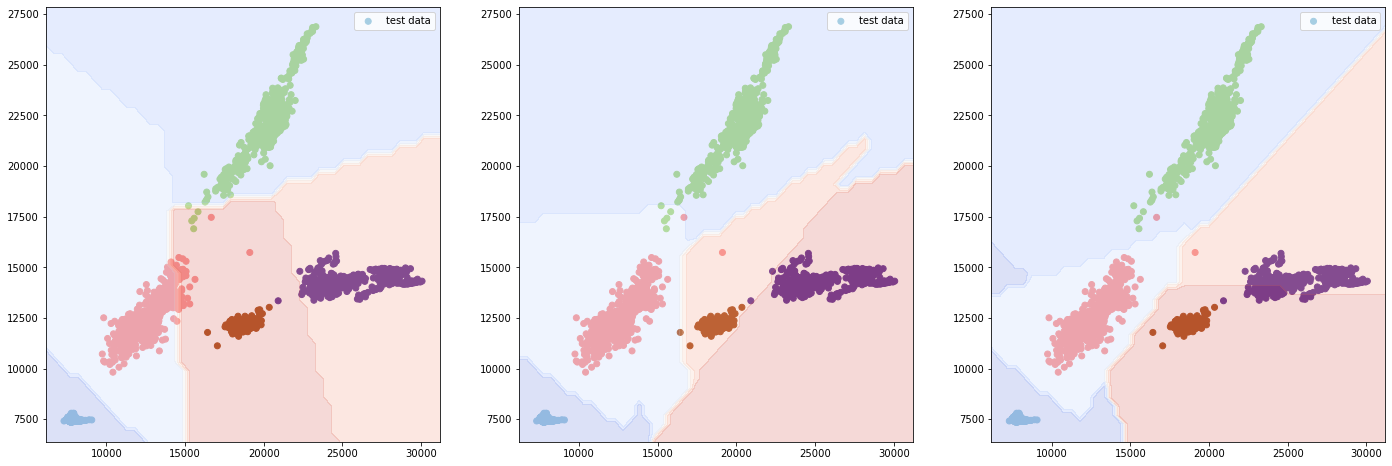

In [128]:
# Now the accuracy changes with different number of iterations.

fig = plt.figure(figsize=(24,8))
for i in range(3):
    
    # This time we plot the decision boundaries again the test dataset
    plt.subplot(1,3,i+1)
    
    svm_lin = SVC(kernel='linear', C=1E6, max_iter=i+1)
    svm_lin.fit(X_train, Y_train)
    
    plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, cmap='Paired', label='test data')
    plot_svc_decision(svm_lin)
    plt.legend()
    
    Y_pred = pd.Series(list(svm_lin.predict(X_test)), name='SVM_lin prediction')  # Store the predicted value in Y_pred
    Y_actu = pd.Series(list(Y_test), name='Manual delineation')
    
    # Now replace the non-intuitive numbers with actual LULC type names and store them into new variables
    Y_actu2 = Y_actu.replace(code_lulc)
    Y_pred2 = Y_pred.replace(code_lulc)
    
    print(classification_report(Y_actu2, Y_pred2))

As can be seen, even briefly after 3 iterations the model started to perform properly, the model still performed poorly in the 2 iteration as the ***Agriculture*** and ***Deciduous forest*** are not differentiated properly. In both the accuracy table in terms of the **precision**, **recall**, and the **F1 score**, and the plots, the two classes are poorly predicted on the test dataset.

Apart from looking at the accuracy table and visualizing the decision boundaries, we can also leverage the information from the **learning curve**! This is again provided by the ***sklearn***. The **learning curve** shows how the model is trained incrementally by further split the training data for model **training** and **validation**, hence, essentially, the data has been split into 3 parts! What we have noticed is that the original data has been split explicitly into **training** and **test** sets, but during training, the **training** set would be further and implicitly split for **training** and **validation**, where the model could actually be trained!

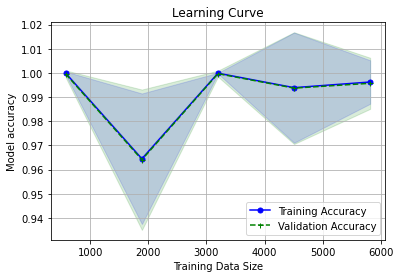

In [137]:
from sklearn.model_selection import learning_curve

import warnings  # Hide warnings for that the data is very easy to classify and may lead to early termination of iteration
warnings.filterwarnings('ignore')

# SVM_lin as before
svm_lin = SVC(kernel='linear', C=1E6, max_iter=i+1)

# This time we play with an even smaller training dataset reasonable performance has been observed above
X_train2, Y_train2, X_test2, Y_test2 = trainTestSplit(data[:,:-1], data[:,-1], 0.8)

# Record the training information
train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(svm_lin, X_train2, Y_train2, cv=30, return_times=True)

# Acquire the recorded details
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

How about **SVM** with non-linear kernel? We would expect the flexiblity of the non-linearity can make more *clean cut* between the data points! Try to inspect how the accuracy will change from using linear kernel to non-linear one? Similarly, we would like to see how the prediction accuracy evolves. Please do try to apply the same procedure of checking accuracy metrics and **learning curve**.

99.94303076338778


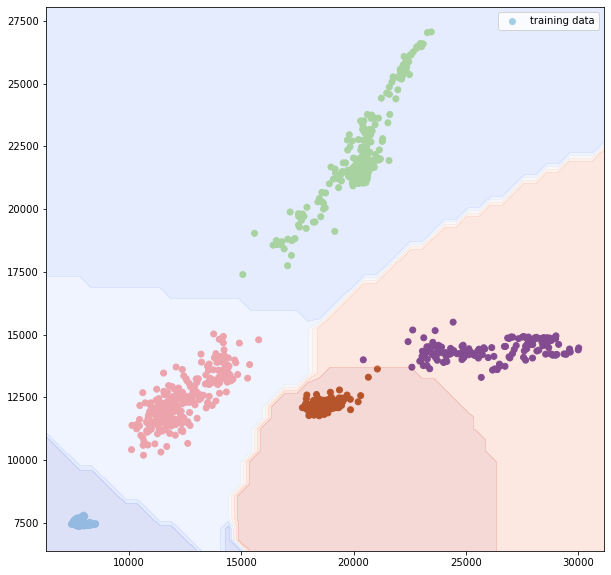

In [139]:
svm_rbf = SVC(kernel='rbf', C=1E6)
svm_rbf.fit(X_train, Y_train)

print(svm_rbf.score(X_test, Y_test)*100)

fig = plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap='Paired', label='training data')
plot_svc_decision(svm_kern)
plt.legend()

Are you satisfied with the results on our small **test** dataset? Let's apply the trained model, either the one with **linear** or the one with **non-linear** kernel, to the entire study area covering the large proportion of the Netherlands. # Do you still have the stacked images? We can direclty apply our model to the stack. Otherwise refer back to the part as we were loading and stacking the input bands.

In [140]:
# Predict on the image stack
# In this case, the more powerful non-linear kernel model is used

Y_pred_all = svm_kern.predict(stack)

Printing large image takes time...


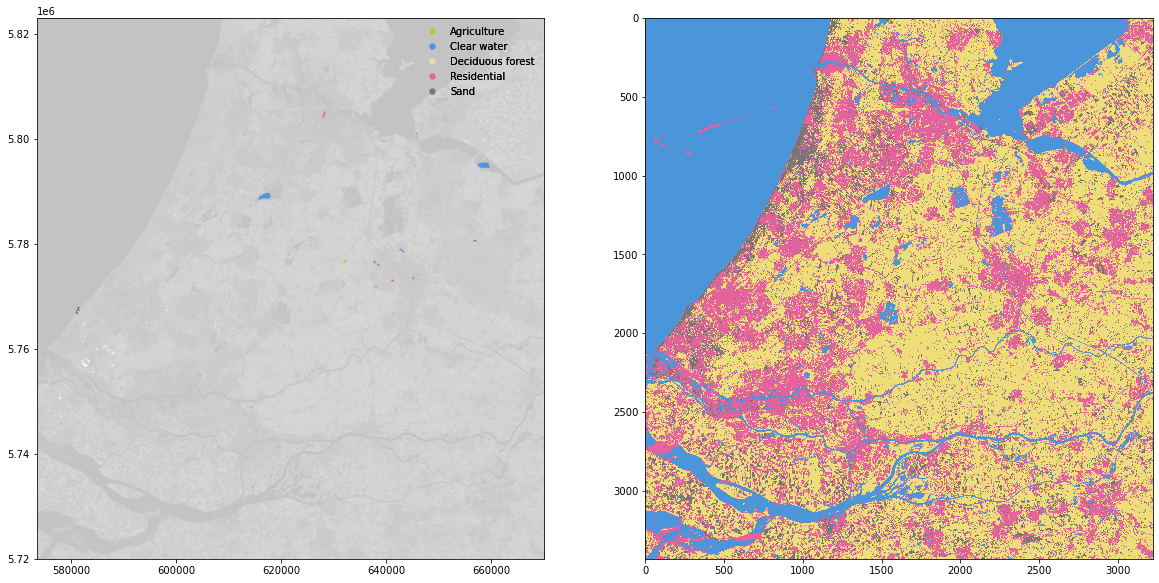

In [141]:
# Then plot the predicted image

# Assign color codes to LULC types 

symbology = {'Agriculture': cols[5],
             'Clear water': cols[20],
             'Deciduous forest': cols[3],
             'Residential': cols[17],
             'Sand': cols[11]}

# Visualize
fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(20,10))
show(b5_2020, ax=ax1, cmap='gray', alpha=0.25)
aoi.plot(ax=ax1, column='land_cover', legend=True, color=aoi['land_cover'].map(symbology))

from matplotlib.lines import Line2D
custom_points = [Line2D([0], [0], marker="o", linestyle="none", markersize=5, color=color) for color in symbology.values()]
leg_points = ax1.legend(custom_points, symbology.keys(), loc='upper right', frameon=False)
ax1.add_artist(leg_points)

symbology2 = {31: cols[17],
              52: cols[5],
              11: cols[20],
              21: cols[11],
              61: cols[3],}

# Visualize
# Because the predicted labels are still in one column, you need to reshape it back to original image shape
row, col = img.shape  # Get the original dimensions of the image
imin = min(symbology2)  # Colormap range
imax = max(symbology2)

print('Printing large image takes time...')
ax2.imshow(Y_pred_all.reshape(row, col), cmap=cm, interpolation='none', vmin=imin, vmax=imax)

As you did with the **K-means**, you are again encouraged to compile your own program in a compact and succint manner by putting the pieces you walked through together. You will then inspect the performance with different inputs and model setups. This time, with the **SVM** as a **supervised learning** algorithm, you need to try different **training data**, and see how the results will be influenced by it. Rember to constantly take advantage of the accuracy table with different metrics, and the **learning curve** to inspect the trainig process. And feel free to compare results across models, such as the those from the **unsupervised learning** algorithms.

In [ ]:
# Start to load image bands you would like to use:

'''
file_list = ['uu_ml/data/b5_2015.TIF', 'uu_ml/data/b6_2015.TIF', ..., ...,]
'''

# Also load different versions of labelled AOIs, and rasterize it:

'''
aoi = gpd.read_file('...')

rst = rasterio.open('...')  # Base image to rasterize the *.shp
meta = rst.meta.copy()  # Copy metadata from the base image
meta.update(compress='lzw')

...
'''

# Train your model and inspect the training processes

'''
from sklearn.model_selection import learning_curve
    ...
    ...
'''

# Evaluate the accuracy with different metrics

'''
...
...
'''

# Generalize your prediction from the trained model to larger areas

'''
...
...
'''